# Modify Macrostrat

This notebook implements a few adjustments to the Macrostrat database:
- new ages for the Sauk transgressive Sixtymile and Tapeats Formations from [Karlstrom et al. (2018)](https://doi.org/10.1038/s41561-018-0131-7), [Karlstrom et al. (2020)](https://doi.org/10.1130/G46755.1)
- accounting for erosion detected by thermochronology on the Slave Craton
    - [Ault et al. (2015)](https://doi.org/10.1016/j.epsl.2014.11.017)
    - [Ault et al. (2013)](https://doi.org/10.1002/tect.20069)
    - [Flowers et al. (2012)](https://doi.org/10.1016/j.epsl.2011.11.015)
    - [Ault et al. (2009)](https://doi.org/10.1016/j.epsl.2009.02.035)
    - [Flowers (2009)](https://doi.org/10.1016/j.epsl.2008.10.005)

In [1]:
import numpy as np
import pandas as pd
import geopandas as gpd
from helper import *
from thefuzz import fuzz
from thefuzz import process
from tqdm.notebook import tqdm

import matplotlib.pyplot as plt

In [2]:
units_seds = load_shapefile('data/units_seds_2023-06.gpkg', 'unit_id', project_id=1)

In [3]:
# also get list of unique environments
env = pd.read_csv('data/environments_2023-06.csv')

# finally put the environment ids into the units dataframe
units_seds['environ_ids'] = env_id(units_seds['environ_y'].values, env)

Generating macrostrat environment IDs:   0%|          | 0/21282 [00:00<?, ?it/s]

## Remove Units with Invalid Chronology

Macrostrat contains units for which the beginning age is younger than the end age, which reflects bugs in its chronology assigning procedure.

In [4]:
print(f'Total number of sedimentary units: {len(units_seds)}')

Total number of sedimentary units: 21282


In [5]:
unit_durations = units_seds['b_age'] - units_seds['t_age']
idx = np.argwhere(unit_durations < 0).squeeze()

units_seds.iloc[idx][['b_age', 't_age', 'col_id']]

,b_age,t_age,col_id
unit_id,,,
2374,260.8600,261.4951,67
2496,260.8600,261.4951,70
2544,261.1975,261.4951,71
2333,262.2100,264.2800,66
3152,262.8850,264.2800,84


There are only five such units in the June 2023 iteration of Macrostrat, as shown above. Let's just remove those.

In [6]:
units_seds.drop(units_seds.iloc[idx].index, inplace=True)

## New Sauk Ages

The new Sauk transgression ages affect the Tapeats and Sixtymile formations. The new basal age for the Sixtymile Formation is a maximum depositional age of 527 Ma. The upper Sixtymile, which is in some places conformable with the overlying Tapeats, has a maximum depositional age around 508 Ma, which is also the age taken for the basal Tapeats. Let's take 504.5 as the age for the upper Tapeats, although this is likely too young (both the Tapeats and Bright Angel were likely deposited in ~4 My).

In [7]:
basal_tapeats = 508
upper_tapeats = 504.5
basal_sixtymile = 527

Let's find the units that would be affected by the new ages, and apply the new ages.

Tapeats:

In [8]:
unit_names_tapeats = process.extractBests('Tapeats', units_seds['unit_name'].unique(), score_cutoff=80)

for unit_name in unit_names_tapeats:
    idx_tapeats = units_seds['unit_name'] == unit_name[0]
    units_seds.loc[idx_tapeats, 'b_int_age'] = basal_tapeats
    units_seds.loc[idx_tapeats, 't_int_age'] = upper_tapeats

Sixtymile:

In [9]:
unit_names_sixtymile = process.extractBests('Sixtymile', units_seds['unit_name'].unique(), score_cutoff=80)

for unit_name in unit_names_sixtymile:
    idx_sixtymile = units_seds['unit_name'] == unit_name[0]
    units_seds.loc[idx_sixtymile, 'b_int_age'] = basal_sixtymile
    units_seds.loc[idx_sixtymile, 't_int_age'] = basal_tapeats

## Erosion on Slave Craton

Several thermochronological measurements across the Slave Craton indicate that cratonic sedimentation (likely due to subduction and mantle dynamnics) occurred during the period 450-375, followed by exhumation until the mid-Jurassic, followed by subsidence and sedimentation from 170-100 and exhumation following then.

Ault et al. (2015) argue that most of the Canadian shield was covered by Paleozoic sediments, which have subsequently been mostly eroded away. For the time being, though, let's only work with the Slave, Churchill Province, and Trans-Hudson Orogen thermochronology, which have excellent data coverage that constrains Paleozoic and Cretaceous subsidence.

### Extract columns

Let's find the columns of interest, in this case outlined by `gis/slave_craton_exposed.shp` and `gis/THO_Churchill.shp`.

In [10]:
# load shield outline
slave = gpd.read_file('gis/slave_craton_exposed.shp')
tho_ch = gpd.read_file('gis/THO_Churchill.shp')

# load columns
columns = load_shapefile('data/columns.gpkg', 'col_id', project_id=1)
columns['col_area'] = [float(x) for x in columns['col_area']]

We need the area of columns within the shield outline, which means that we'll need our geodataframes to have area-preserving projections, like the equal earth projection (*EPSG: 8857*).

In [11]:
# set crs
epsg = 8857
proj4 = 'epsg:%d' % epsg

columns = columns.to_crs(proj4)
slave = slave.to_crs(proj4)
tho_ch = tho_ch.to_crs(proj4)

Find intersection of columns with the outlines of the shapefiles, and compute the areas.

In [12]:
slave_columns = gpd.overlay(columns, slave, how='intersection')
slave_columns['slave area'] = slave_columns.area
slave_columns.set_index('col_id', drop=False, inplace=True)

tho_ch_columns = gpd.overlay(columns, tho_ch, how='intersection')
tho_ch_columns['tho_ch area'] = tho_ch_columns.area
tho_ch_columns.set_index('col_id', drop=False, inplace=True)

Now find the fraction of each column's area within the outlined regions.

In [13]:
# merge slave columns with columns to add area of each column in slave to main column dataframe
columns_slave = columns.merge(slave_columns[['col_name', 'slave area']], left_index=True, right_index=True, how='outer')

# replace nans
columns_slave['slave area'].fillna(0, inplace=True)

# compute fraction within slave polygon
columns_slave['frac in slave'] = columns_slave['slave area']/columns.area

# merge tho_ch columns with columns to add area of each column in tho_ch to main column dataframe
columns_tho_ch = columns.merge(tho_ch_columns[['col_name', 'tho_ch area']], left_index=True, right_index=True, how='outer')

# replace nans
columns_tho_ch['tho_ch area'].fillna(0, inplace=True)

# compute fraction within tho_ch polygon
columns_tho_ch['frac in tho_ch'] = columns_tho_ch['tho_ch area']/columns.area

Sanity check plot

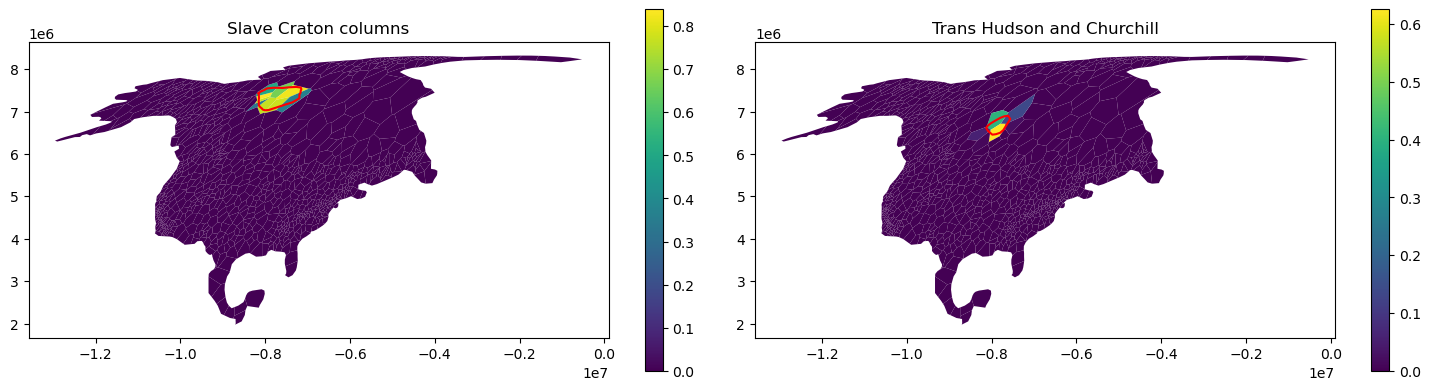

In [14]:
fig, ax = plt.subplots(1, 2, figsize=(15, 4))

columns_slave.plot(column='frac in slave', cmap='viridis', legend=True, ax=ax[0])
slave.boundary.plot(ax=ax[0], color='r')
ax[0].set_title('Slave Craton columns')

columns_tho_ch.plot(column='frac in tho_ch', cmap='viridis', legend=True, ax=ax[1])
tho_ch.boundary.plot(ax=ax[1], color='r')
ax[1].set_title('Trans Hudson and Churchill')

plt.tight_layout()
plt.show()

Let's just take columns that are 50% or more part of the shield.

In [15]:
idx_slave_col = columns_slave['frac in slave'] > 0.35
idx_tho_ch_col = columns_tho_ch['frac in tho_ch'] > 0.35

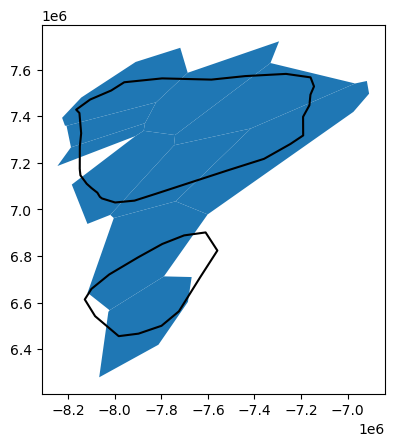

In [16]:
ax = columns_slave[idx_slave_col].plot()
columns_tho_ch[idx_tho_ch_col].plot(ax=ax)
slave.boundary.plot(ax=ax, color='k')
tho_ch.boundary.plot(ax=ax, color='k')


plt.show()

#### Figure showing extracted columns

In [17]:
from pyproj import CRS

plot_proj = CRS.from_proj4('+proj=tmerc +lat_0=0 +lon_0=-104 +k=0.926 +x_0=500000 +y_0=-4500000 +ellps=clrk66 +units=m +no_defs')

In [18]:
# political boundaries
bound = gpd.read_file('gis/political_boundaries/boundaries_national.shp')
bound_plot = bound.to_crs(plot_proj)
bound_plot = bound_plot[bound_plot['CONTINENT'] == 'North America']

In [19]:
# thermochron data sourcse
thermo = gpd.read_file('gis/Slave_THO_thermochron.shp')
thermo_plot = thermo.to_crs(plot_proj)

In [20]:
slave_plot = slave.to_crs(plot_proj)
tho_ch_plot = tho_ch.to_crs(plot_proj)
columns_plot = columns.to_crs(plot_proj)

C:\Users\adrian\AppData\Local\Temp\ipykernel_19168\1823745217.py:19: UserWarning: Legend does not support handles for PatchCollection instances.
See: https://matplotlib.org/stable/tutorials/intermediate/legend_guide.html#implementing-a-custom-legend-handler
  han, lab = ax.get_legend_handles_labels()


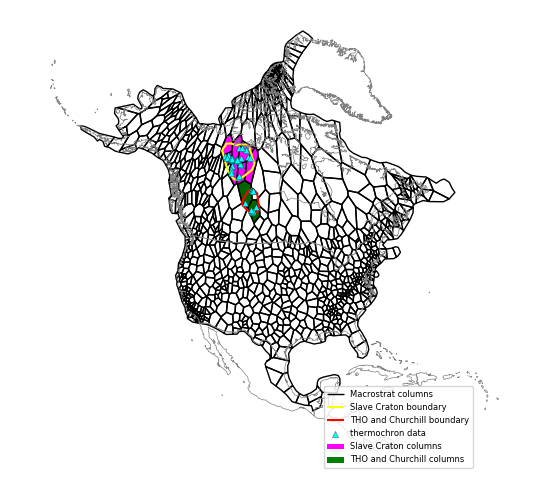

In [21]:
import matplotlib.patches as mpatches

ax = columns_plot.boundary.plot(linewidth=1, color='k', label='Macrostrat columns', figsize=(7,6))

# Slave Craton
slave_plot.boundary.plot(ax=ax, color='yellow', label='Slave Craton boundary')
l1 = columns_plot[idx_slave_col].plot(ax=ax, label='Slave Craton columns', color='magenta')
bound_plot.boundary.plot(ax=ax, color='gray', linewidth=0.5)

# Trans Hudson and Churchill
tho_ch_plot.boundary.plot(ax=ax, color='red', label='THO and Churchill boundary')
l2 = columns_plot[idx_tho_ch_col].plot(ax=ax, label='THO and Churchill columns', color='darkgreen')

# data sources
thermo_plot.plot(ax=ax, color='cyan', label='thermochron data', marker='^', markersize=20, zorder=10, edgecolor='k', linewidth=0.2)

# make legend patches
patch = mpatches.Rectangle([0, 0], 0, 0, facecolor='magenta')
han, lab = ax.get_legend_handles_labels()
han.append(patch)
lab.append('Slave Craton columns')
patch = mpatches.Rectangle([0, 0], 0, 0, facecolor='green')
han.append(patch)
lab.append('THO and Churchill columns')

leg = ax.legend(han, lab, loc='lower left', bbox_to_anchor=(0.6, 0), fontsize=6)
ax.set_xlim([-4500000, 6000000])
# ax.set_ylim([1.7e6, 8.5e6])

ax.axis('off')

# plt.savefig('figures/shield_columns.pdf', format='pdf', bbox_inches='tight')

plt.show()

### Add eroded units

Having identified these columns, we'll re-add sedimentary cover corresponding to what we infer as eroded during the Phanerozoic for each domain.

For the Slave Craton, let's impose the Phanerozoic sedimentation argued for by Ault et al. (2015). We'll basically need to add new units to these columns that record sedimentation within that time window.

<img src='figures_literature/Ault2015_Figure2.png' width="400">

Figure 2 from Ault et al. (2015).

For the Trans-Hudson Orogeny and Churchill Province, which don't exhibit the same Mesozoic burial history as the Slave Craton, we will use the burial histories as presented in Flowers et al. (2012).

<img src='figures_literature/Flowers2012_Figure1.png' width="500">

Figure 1 from Flowers et al. (2012).

Each column will have two new units: one corresponding to sedimentation during the Paleozoic, and another for sedimentation during the Mesozoic. The only properties I set for the moment are the continuous age model top and bottom ages, as well as the thicknesses and inferred environmental id of 93 corresponding to an inferred marine environment.

In [22]:
t1_slave = 450
t2_slave = 375
t3_slave = 170
t4_slave = 90

thick_paleozoic_slave = 2800
thick_mesozoic_slave = 1400

t1_tho_ch = 430
t2_tho_ch = 300

thick_paleozoic_tho_ch = 2500 # conservative estimate

# number of columns
n_slave_col = np.sum(idx_slave_col)
n_tho_ch_col = np.sum(idx_tho_ch_col)

# create unit indices, one for each column and depositional
idx_new_units_slave = np.max(units_seds.index) + np.arange(1, 2*n_slave_col+1)
idx_new_units_tho_ch = np.max(idx_new_units_slave) + np.arange(1, 2*n_tho_ch_col+1)


# create a unit for each column spanning Paleozoic sedimentation
slave_units = pd.DataFrame(index=idx_new_units_slave, columns=list(units_seds))
slave_units.index.name = 'unit_id'

tho_ch_units = pd.DataFrame(index=idx_new_units_tho_ch, columns=list(units_seds))
tho_ch_units.index.name = 'unit_id'

Paleozoic Units

In [23]:
# set column ids
slave_units['col_id'].iloc[0:n_slave_col] = columns.index[idx_slave_col].values

# set ages
slave_units['b_age'].iloc[0:n_slave_col] = t1_slave
slave_units['t_age'].iloc[0:n_slave_col] = t2_slave

# set thickness
slave_units['min_thick'].iloc[0:n_slave_col] = thick_paleozoic_slave

# set environ string (inferred marine)
slave_units['environ_y'].iloc[0:n_slave_col] = 'inferred marine  marine '

# set area
slave_units['col_area'].iloc[0:n_slave_col] = columns.loc[idx_slave_col, 'col_area']


# set column ids
tho_ch_units['col_id'].iloc[0:n_tho_ch_col] = columns.index[idx_tho_ch_col].values

# set ages
tho_ch_units['b_age'].iloc[0:n_tho_ch_col] = t1_tho_ch
tho_ch_units['t_age'].iloc[0:n_tho_ch_col] = t2_tho_ch

# set thickness
tho_ch_units['min_thick'].iloc[0:n_tho_ch_col] = thick_paleozoic_tho_ch

# set environ string (inferred marine)
tho_ch_units['environ_y'].iloc[0:n_tho_ch_col] = 'inferred marine  marine '

# set area
tho_ch_units['col_area'].iloc[0:n_tho_ch_col] = columns.loc[idx_tho_ch_col, 'col_area']

Mesozoic Units

In [24]:
# set column ids
slave_units['col_id'].iloc[n_slave_col:] = columns.index[idx_slave_col].values

# set ages
slave_units['b_age'].iloc[n_slave_col:] = t3_slave
slave_units['t_age'].iloc[n_slave_col:] = t4_slave

# set thickness
slave_units['max_thick'].iloc[n_slave_col:] = thick_mesozoic_slave

# set environ (inferred marine)
slave_units['environ_y'].iloc[n_slave_col:] = 'inferred marine  marine '

# set area
slave_units['col_area'].iloc[n_slave_col:] = columns.loc[idx_slave_col, 'col_area']

## Removing Pleistocene Units

Because the glacioisostasy has strongly influenced much of North America since the Pleistocene, which is recorded (at least for now) as sediments that are interpreted as marine, let's just remove those since they don't reflect the tectonic processes that affect sea level, which is what we're interested in.

In [25]:
units_seds.drop(units_seds[units_seds['b_int_age'] <= 3].index, inplace=True)

## Save modified units dataframe

After applying the modifications above, let's save the modified units dataframe as a separate file.

In [26]:
# merge slave units with the units_seds dataframe
units_seds_mod = pd.concat([units_seds, slave_units, tho_ch_units])

# saveunits_seds.drop(units_seds.iloc[idx].index)
units_seds_mod.to_csv('data/units_seds_mod_no-pleis_2023-06.csv')